# Informe nº4
    Notas: breve actualización del TFG. Exposición de los métodos de estiamción de radiación difusa.
    Fecha: 06/06/2020

   ### Definición de todas los parámetros disponibles       
    Se realizará una exposición de los parámetros que pueden llegar a ser utilizados en la estimación de la radiación difusa.
   
   ### Definición de los métodos para la evaluación de los modelos propuestos
    Se definirán los métodos que nos permiten evaluar la calidad del modelo propuesto.
   
   ### Exposisicón de los métodos de regresión lineal
    Uso de métodos lineales para la estimación de la radiación difusa.

   ### Exposición de los métodos de regresión polinómica
    Uso de métodos polinomicos paara la estimación de la radiación difusa.

   ### Resultados y consulsiones

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

### Definición de todas los parámetros disponibles  
     Como vimos en el infrome anterior, disponemos de muchos parámetros que pueden ser utilizados en la estimación de la radiación difusa. Con el fin de obtener el modelo que más se ajuste a la realidad, debemos hacer una seleccion de estos parámatros en función del modelo utilizado. Disponemos de muchos métodos para la indentifiación de los parámetros adecaudos. A continuación, se exponen todos los parámetros de los que disponemos.

<Figure size 432x288 with 0 Axes>

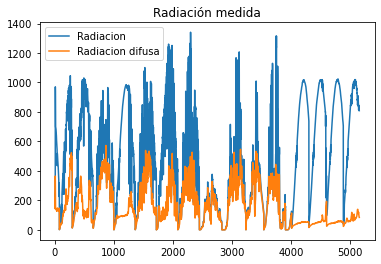

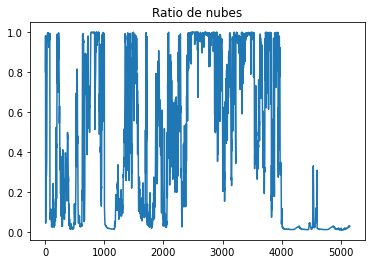

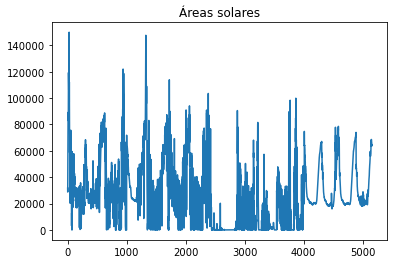

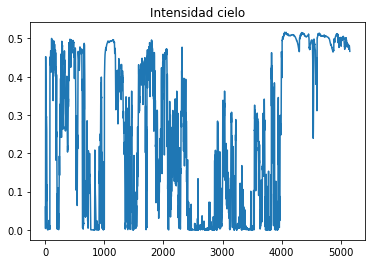

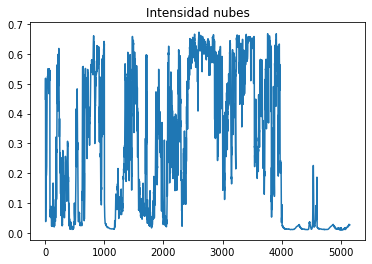

In [2]:
# Se lee los datos con los que se realizará la estimación
pd_info_regresion = pd.read_csv('Datos/info_regresion.csv')

pd_info_regresion['Intensidad nubes'] *= pd_info_regresion['Ratio nubes']
pd_info_regresion['Intensidad cielo'] *= 1 - pd_info_regresion['Ratio nubes']

# Se muestran los datos
plt.figure(1)
fig, ax = plt.subplots()
pd_info_regresion['Radiacion'].plot(title='Radiación medida', legend=True)
pd_info_regresion['Radiacion difusa'].plot(legend=True)

plt.figure(3)
pd_info_regresion['Ratio nubes'].plot(title='Ratio de nubes', legend=False)

plt.figure(4)
pd_info_regresion['Área solar'].plot(title='Áreas solares', legend=False)

plt.figure(5)
pd_info_regresion['Intensidad cielo'].plot(title='Intensidad cielo', legend=False)

plt.figure(6)
pd_info_regresion['Intensidad nubes'].plot(title='Intensidad nubes', legend=False)

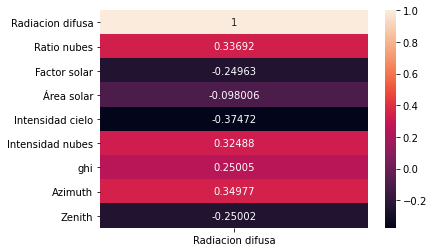

In [3]:
Corr_matrix = pd_info_regresion.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['Radiacion'])

import seaborn as sn
sn.heatmap(correlacion_difusa, annot=True,  fmt='.5g')
plt.show()

### Definición de los métodos para la evaluación de los modelos propuestos

Para la realiazación de modelos predictivos es necesario el uso de dos conjuntos de datos, el primero suele ser más extenso, y el usado para la realización del modelo. Por otro lado, existe un conjunto con el que se realiza el testeado del modelo. Mediante el testado, se comprueba la validez de los modelos, los métodos que se exponene a continuación serán los utlizados en este proyecto para la evaluación de los modelos obtenidos.

+ Puntuación R2, coeficiente de determinación: determina la calidad del modelo para replicar los resulados, junto con la proporción de la variación que puede ser obtenida por el modelo. Este coeficiente no es aduecuado cuando se trabaja con distintos conjuntos de datos, pero nos puede aportar información adiacional de la calidad de los métodos utilizados.

+ Raíz del error cuadrático medio, RMSE: es un factor frecuentemente utilizado en métodos estadísticos en los que se desea comparar dos conjutnos de datos. Este será un factor importante a considerar, ya que nos propoerciona el error(absoluto) entre los datos reales y estimados.

+ Puntuación de varainza explicada(en inglés, explained variance score): en estadística, la varainza explicada proporciona una medida de cómo un modelo matemático se comporta ante la variación de un conjunto de datos dado.
                                explained_variance(Y,Y') = 1 - Var{Y - Y'} / Var{Y}
  Siendo Y el conjunto de datos medidos, o reales, e Y' el conjunto de datos obtenido por el estimador.

+ Observación del error obtenido: aunque no sea un método como tal, la observación del error nos puede aprotar infromación sobre la calidad del método utilizado.

### Exposisicón de los métodos de regresión lineal
    A contianuacion, se expone el resultado de aplicar un método de regresión lineal al conjunto de datos global, junto con los resultados de la estimaciñon utilizando el conjunto de datos de test.

In [4]:
# Se lee los datos con los que se realizará la estimación
pd_info_regresion = pd.read_csv('Datos/info_regresion.csv')

pd_info_regresion['Intensidad nubes'] *= pd_info_regresion['Ratio nubes']
pd_info_regresion['Intensidad cielo'] *= 1 - pd_info_regresion['Ratio nubes']

# Se definen las variables de la estimación
y_rad = pd_info_regresion['Radiacion difusa']
x_rad = pd_info_regresion[['ghi', 'Ratio nubes', 'Intensidad nubes']]

# Se leen los datos utilziados para el test
pd_info_regresion_test = pd.read_csv('Datos/info_regresion_test_nublado.csv')

pd_info_regresion_test['Intensidad nubes'] *= pd_info_regresion_test['Ratio nubes']
pd_info_regresion_test['Intensidad cielo'] *= 1 - pd_info_regresion_test['Ratio nubes']

In [5]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad, y_rad)

score = reg.score(x_rad, y_rad)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.22.


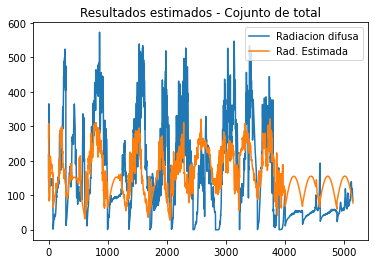

In [6]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion)):
    predicted_rad.append(reg.predict([pd_info_regresion[['ghi', 'Ratio nubes', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados estimados - Cojunto de total', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

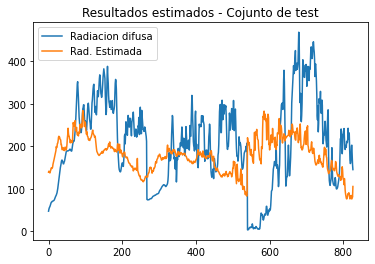

In [7]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test)):
    predicted_rad.append(reg.predict([pd_info_regresion_test[['ghi', 'Ratio nubes', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados estimados - Cojunto de test', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

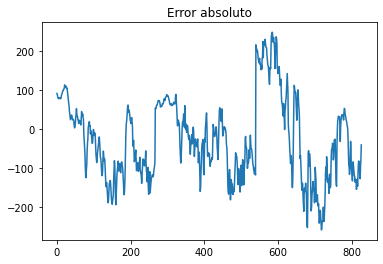

In [8]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

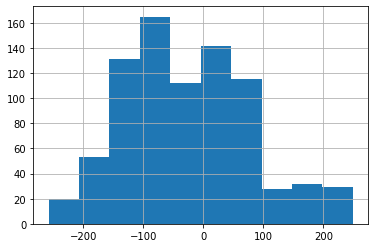

In [9]:
errores.hist()

In [10]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 107.50.
La puntuación de varianza explicada es -0.10.


Se ha observado que los resultados obtenidos no son muy satifactorios. A continuación, se ha planteado el uso de dos modelos distintos, uno en caso de que el cielo, y el sol, esté despejado y otro en el que se considera que el cielo se encuentra nublado. Para differenciar el modelo que hay que utilizar en cada caso, se han expuesto los factotres solares y el ratio de nubes de cada conjunto de datos:

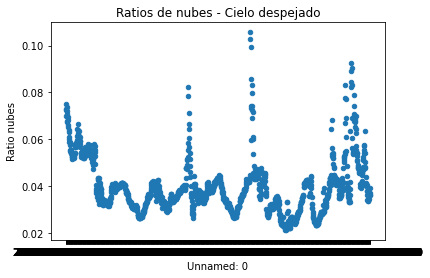

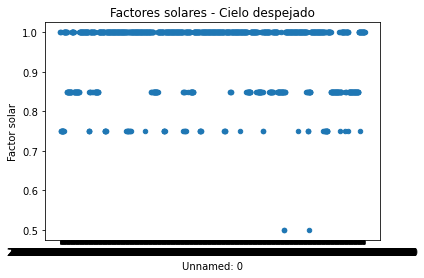

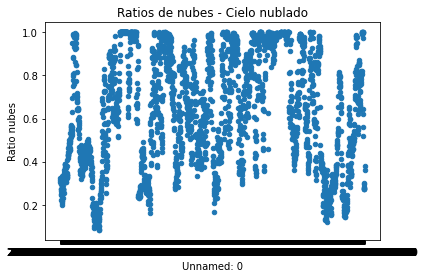

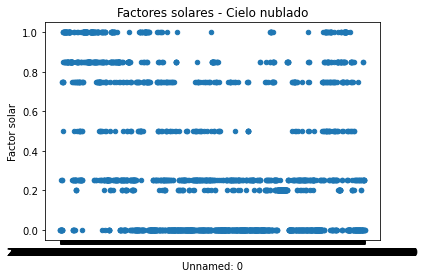

In [11]:
# Lectura de los conjutnos de datos referencia
pd_info_regresion_despejado = pd.read_csv('Datos/info_regresion_despejado.csv')
pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado.csv')

# Datos de cielo despejado
pd_info_regresion_despejado.plot.scatter(x=0, y='Ratio nubes', title='Ratios de nubes - Cielo despejado')
pd_info_regresion_despejado.plot.scatter(x=0, y='Factor solar', title='Factores solares - Cielo despejado')
 
# Datos de cielo nublado
pd_info_regresion_nublado.plot.scatter(x=0, y='Ratio nubes', title='Ratios de nubes - Cielo nublado')
pd_info_regresion_nublado.plot.scatter(x=0, y='Factor solar', title='Factores solares - Cielo nublado')

Observamos que en la gran mayoría de casos, en el modelo despejado, el ratio de nubes es inferior a un 10% acompañado de un factor solar superior a 0.7. Pode este motivo, se han definido estos valores como límite entre ambos modelos. Es decir, cualquier imagen del cielo, que presente un ratio de nubes inferior a un 10% y con un factor solar superior a 0.75, se tratará parte del modelo de cielo despejado.

#### Cielo despejado
    Se muestran a continuación los resultados de la regresión lineal con el conjunto de datos del cielo despejado.

In [12]:
pd_info_regresion_despejado['Intensidad nubes'] *= pd_info_regresion_despejado['Ratio nubes']
pd_info_regresion_despejado['Intensidad cielo'] *= 1 - pd_info_regresion_despejado['Ratio nubes']

# Se definen las variables de la estimación
y_rad_despejado = pd_info_regresion_despejado['Radiacion difusa']
x_rad_despejado = pd_info_regresion_despejado[['ghi', 'Ratio nubes', 'Intensidad cielo', 'Intensidad nubes']]

# Se leen los datos utilziados para el test
pd_info_regresion_test_despejado = pd.read_csv('Datos/info_regresion_test_despejado.csv')

pd_info_regresion_test_despejado['Intensidad nubes'] *= pd_info_regresion_test_despejado['Ratio nubes']
pd_info_regresion_test_despejado['Intensidad cielo'] *= 1 - pd_info_regresion_test_despejado['Ratio nubes']

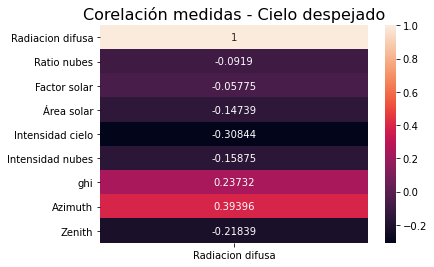

In [13]:
Corr_matrix = pd_info_regresion_despejado.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['Radiacion'])

import seaborn as sn
sn.heatmap(correlacion_difusa, annot=True,  fmt='.5g')
plt.title('Corelación medidas - Cielo despejado', fontsize = 16)
plt.show()

In [14]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad_despejado, y_rad_despejado)

score = reg.score(x_rad_despejado, y_rad_despejado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.56.


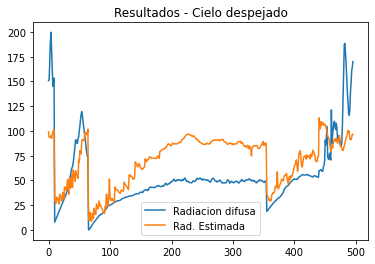

In [15]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_despejado)):
    predicted_rad.append(reg.predict([pd_info_regresion_test_despejado[['ghi', 'Ratio nubes','Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_despejado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados - Cielo despejado', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

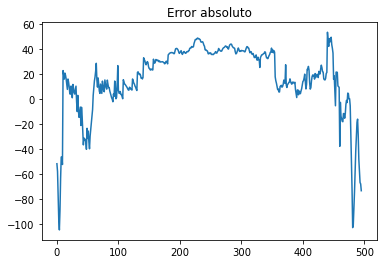

In [16]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo despejado')

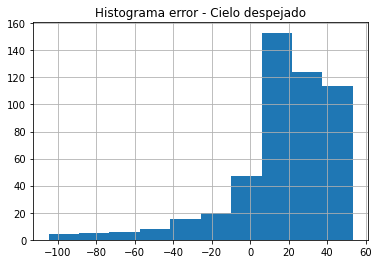

In [17]:
errores.hist()
plt.title('Histograma error - Cielo despejado')

In [18]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 31.57.
La puntuación de varianza explicada es 0.32.


#### Cielo nublado
    De forma similar al cielo despejado, se exponen los resultados con el conjunto de datos de cielo nublado.

In [19]:
pd_info_regresion_nublado['Intensidad nubes'] *= pd_info_regresion_nublado['Ratio nubes']
pd_info_regresion_nublado['Intensidad cielo'] *= 1 - pd_info_regresion_nublado['Ratio nubes']

# Se definen las variables de la estimación
y_rad_nublado = pd_info_regresion_nublado['Radiacion difusa']
x_rad_nublado = pd_info_regresion_nublado[['ghi', 'Ratio nubes', 'Intensidad cielo', 'Intensidad nubes']]

# Se leen los datos utilziados para el test
pd_info_regresion_test_nublado = pd.read_csv('Datos/info_regresion_test_nublado.csv')

pd_info_regresion_test_nublado['Intensidad nubes'] *= pd_info_regresion_test_nublado['Ratio nubes']
pd_info_regresion_test_nublado['Intensidad cielo'] *= 1 - pd_info_regresion_test_nublado['Ratio nubes']

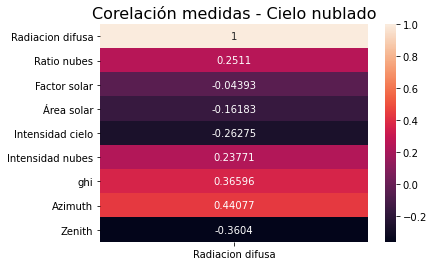

In [20]:
Corr_matrix = pd_info_regresion_nublado.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['Radiacion'])

import seaborn as sn
sn.heatmap(correlacion_difusa, annot=True,  fmt='.5g')
plt.title('Corelación medidas - Cielo nublado', fontsize = 16)
plt.show()

In [21]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad_nublado, y_rad_nublado)

score = reg.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.20.


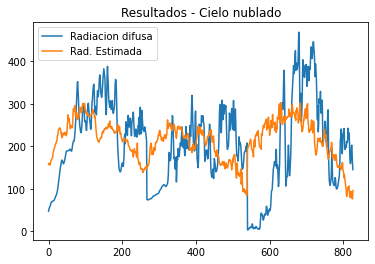

In [22]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(reg.predict([pd_info_regresion_test_nublado[['ghi', 'Ratio nubes','Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados - Cielo nublado', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

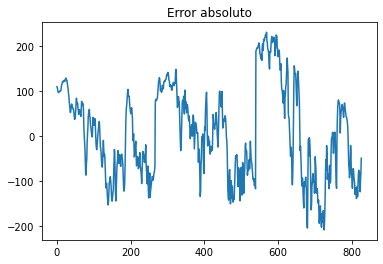

In [23]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo nublado')

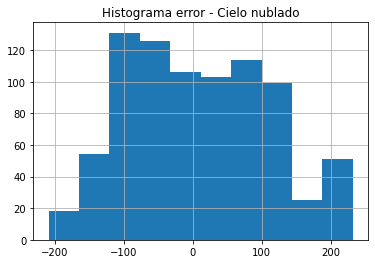

In [24]:
errores.hist()
plt.title('Histograma error - Cielo nublado')

In [25]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 101.20.
La puntuación de varianza explicada es -0.03.


Obsrvando los rsultados de la distinión de los cielo, y comparandolos con el modelo simplificado, podemos observar que el error a disminuido siginificativamente, además, los modelos se ajustan mejor a los valores reales. Por estos motivos, se ha decidido que se realizará esta segmentación, abandonando el modelo simplificado.

### Exposición de los métodos de regresión polinómica
    Se cree que un modelo lineal no es el más adecuado para la estimación de la radiación difusa, por las características no-lieanles de este fenómeno, por lo que se proponen el uso de modelos de mayor grado. Como comentamos anteriormente, se realizará la distincion entre cielos despejados y nublados, con el fin de obtener unos resultados más precisos.

#### Cielo despejado

Se ha observado que el grado que mejor se ajusta a los models, en ambos tipos de cielo, es 3. Además, no es aconsejable aumentar el grado del polinnómio excesivamente, ya que pequeños cambios en los parámetros de entrada puede suponer grandes variaciones de la radiación difusa, disminuyendo significativamente la puntuación de varianza explicada.

In [26]:
# Definición del grado de los polinómios
grados = 3

In [27]:
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_despejado, y_rad_despejado)

score = model.score(x_rad_despejado, y_rad_despejado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.73.


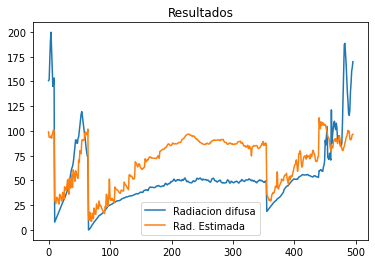

In [28]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_despejado)):
    predicted_rad.append(model.predict([pd_info_regresion_test_despejado[['ghi', 'Ratio nubes','Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_despejado
pd_predicted['Rad. Predecida'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

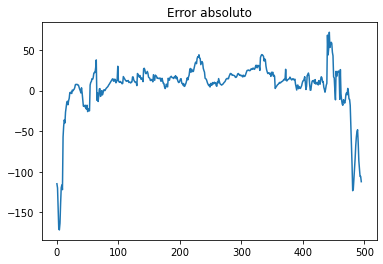

In [29]:
errores = pd_predicted['Rad. Predecida'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo despejado')

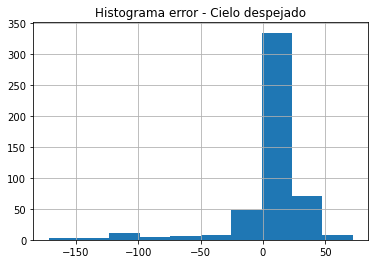

In [30]:
errores.hist()
plt.title('Histograma error - Cielo despejado')

In [31]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 31.57
La puntuación de varianza explicada es 0.32.


#### Cielo nublado

In [32]:
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_nublado, y_rad_nublado)

score = model.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.37.


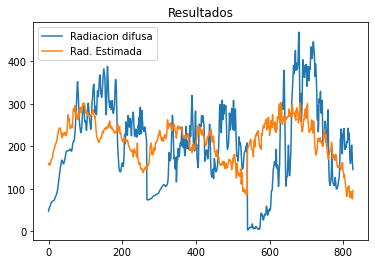

In [33]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(model.predict([pd_info_regresion_test_nublado[['ghi', 'Ratio nubes','Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Predecida'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

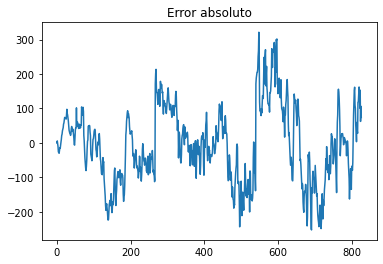

In [34]:
errores = pd_predicted['Rad. Predecida'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo nublado')

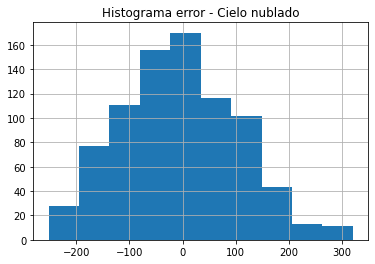

In [35]:
errores.hist()
plt.title('Histograma error - Cielo nublado')

In [36]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 101.20.
La puntuación de varianza explicada es -0.03.


Podemos observar que en este caso, el resutado es mejor, que en el modelo lineal, en algunos de los casos.

Gracias a las estaciones meteo del IES tenemos a nuestra disposición la medida instantánea de la radiación global recibida, por este motivo se ha decidido añadir la radiación global como un parámetro más en la estimación, utizando los parámetros que están a nuestra disposición junto con la radiación medida se cree que se puden obtener mejores resultados. A continuación se exponen los modelos de estimación de la radiación difusa, teniendo como uno de los parámetros las radiación global medida.

#### Cielo despejado

In [37]:
# Se definen las variables de la estimación
y_rad_despejado = pd_info_regresion_despejado['Radiacion difusa']
x_rad_despejado = pd_info_regresion_despejado[['Radiacion', 'Intensidad cielo', 'Intensidad nubes']]

model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_despejado, y_rad_despejado)

score = model.score(x_rad_despejado, y_rad_despejado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.69.


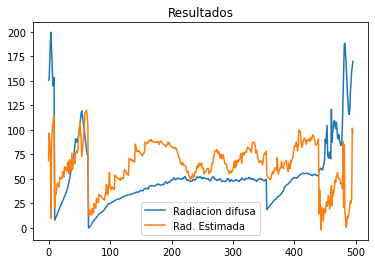

In [38]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_despejado)):
    predicted_rad.append(model.predict([pd_info_regresion_test_despejado[['Radiacion', 'Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_despejado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

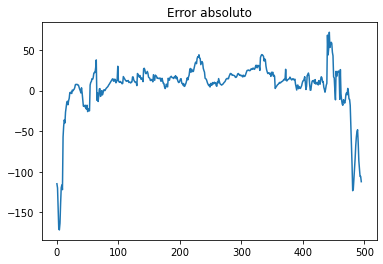

In [39]:
errores = pd_predicted['Rad. Predecida'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo despejado')

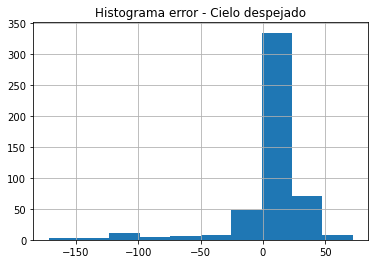

In [40]:
errores.hist()
plt.title('Histograma error - Cielo despejado')

In [41]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 39.32
La puntuación de varianza explicada es -0.36.


#### Cielo nublado

In [42]:
# Se definen las variables de la estimación
y_rad_nublado = pd_info_regresion_nublado['Radiacion difusa']
x_rad_nublado = pd_info_regresion_nublado[['Radiacion', 'Intensidad cielo', 'Intensidad nubes']]

model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_nublado, y_rad_nublado)

score = model.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.66.


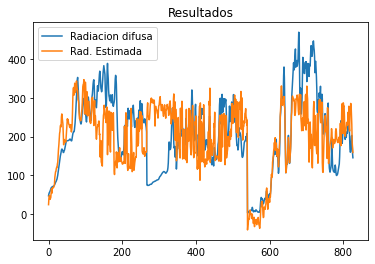

In [43]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(model.predict([pd_info_regresion_test_nublado[['Radiacion', 'Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

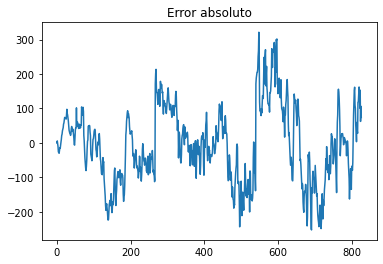

In [44]:
errores = pd_predicted['Rad. Predecida'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Text(0.5, 1.0, 'Histograma error - Cielo nublado')

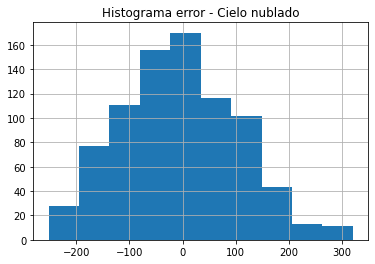

In [45]:
errores.hist()
plt.title('Histograma error - Cielo nublado')

In [46]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Predecida'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Predecida'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 110.06.
La puntuación de varianza explicada es -0.22.


### Resultados y consulsiones

En resumen, los resutados obtenidos son:
+ Métodos de regresión lineales:
    * Sin realizar separación entre tipos de cielos: R2: 0.36, RMSE: 111, Varianza explicada: 0.09.
        - Comentarios adicionales: se observan unos resultados mediocres. No es un método adecuado ya que otros presentan muchos mejores resultados.
    * Con cielos despejados: R2: 0.56, RMSE: 32, Varianza explicada: 0.32.
        - Comentarios adicionales: en función de los resultados obtenidos, observamos que se producen grandes errores en la estimación realizada en los momentos del mediodía.
    * Con cielos nublados: R2: 0.2, RMSE: 101, Varianza explicada: -0.03.
        - Comentarios adicionales: la forma que se observa de las funciones es similar, aunque en muchos casos presenta un error bastante elevado. 
        
+ Métodos de regresión polinomicos:
    * Con cielos despejados: R2: 0.73, RMSE: 32, Varianza explicada: 0.05.
        - Comentarios adicionales: es el mejor método para la estimación de la radiación difusa con cielos despejados. Aunque presenta una mayor varianza que en los métodos lineales, la similutud entre ambas funciones es mayor, presentando un RMSE similar.
    * Con cielos nublados: R2: 0.37, RMSE: 110, Varianza explicada: -0.22.
        - Comentarios adicionales: los resultados obtenidos no son del todo adecuados. Ambas funciones tienen cierto grado de similitud pero el error que existe es elevado. 
        
+ Modelos de regresión polinómica conociendo la radiación global:
    * Con cielos despejados: R2: 0.69, RMSE: 39, Varianza explicada: -0.36.
        - Comentarios adicionales: en un método que presenta una varianza demasiado baja, además, el RMSE es más elevado que el de otros métodos, sin mencioanr que observando las funciones podemos decir que no es un método adecuado. 
    * Con cielos nublados: R2: 0.66, RMSE: 88, Varianza explicada: 0.21.
        - Comentarios adicionales: es el método más adecuado para la estimación de la radiación difusa en cielo nublados, aunque con él no obtengamos resultados muy acertados. Presenta un RMSE más bajo que en el caso de no uilizar la radiación global, además la forma de la función obtenida es similar a la real.

Podemos sacar como conclusión que los método lineales no son adecuados en este proyecto, o por lo menos no tan adecuados como los polinónimos. Observamos que aún con métodos no-lineales el error obtenido en la estimación sigue siendo muy elevado. El método que mejor se adapta a los cielos despejado es el polinómio, sin utilizar la radiación global. Por otro lado, para los cielos nublados, el mejor método es la estimación mediante el uso de la radiación global, junto con los métodos de regresión polinómica. Este método presenta los mejores resulatdos en cielos en los que se encuentran nubes blancas. En cielos que presentan nubes de color gris, características de las tomentas, no se obitienen resulatdos muy acertados, por este motivo un clasificador de nubes puede ser una herramienta adecuada a implemntar para mejorar este método.

# Comentarios 
+ Como hemos comentado al principio, no todos los parámetros son adecuado para la estimación, algunos empeoran el modelo. Los resultados respresentados en este informe corresponden a los obtenidos una vez se han indentificado los parámetros adecuados en cada caso. Para esta identificación se ha seguido el proceso explicado en el informe, se han observado los indicadores de calidad del estimador y se han seleccionado los parámetros que prorpocionen los mejores resulatdos.
+ El conjunto de datos para la realización del modelo se ha obtenido con las medidas del mes de mayo y, para el conjunto de datos de test, se han utilizado las medidas de la primera semana de junio, del 02-06 al 07-06.